# Stochastic Process Theories for Income Distribution
_By_ Alex Carrasco (Jan, 2021)

**Empirical Regularity**. In contrast to physical and biological worlds, where distributions tend to be symmetric and bell-shaped, in social science, size (e.g., income) distribution tend to: (i) be skweed to the right (asymetric) and (ii) have fat tails (leptokurtic). Put differently, mean income always exceed median earnings and the top percentiles of earners account for a strikingly disproportionate share of total earnings.

**Goal**. In this notebook, we explore stochastic process theories that focus on generating size distributions with the above-described properties. To do so, we consider the individual income $y$ as an stochastic variable which depends on several factors $\epsilon_1,\dots,\epsilon_K$, i.e.,
$$ y = F(\epsilon_1,\dots,\epsilon_K)$$
Therefore, the goal is to determine a _generative mechanism_: stochastic process generating $\epsilon_1,\dots,\epsilon_K$ and a particular aggregator $F(.)$, such that, the distribution of $y$ has the above-described properties (i-ii). The notebook is focused on income distribution.

**Julia**. To complement the revision of these theories with practica examples, we use Julia. Then, lets inialize the Julia kernel by activating the packages used through the notebook. 

In [1]:
using Statistics, Distributions, LinearAlgebra, Random, Plots, StatsPlots;

## Gibrat's law and Log-normal distribution
Due the central limit theorem, $F$ cannot be a simple sum with $\epsilon_1,\dots,\epsilon_K$ identical and independent distributed. Gibrat (1931), influenced by the astronomer Jacobus Kapteyn, postulated that the simplest process to generate skew distributions is $F(\mathbf{x})=\prod_{i}^K x_i=\exp\left(\sum_{i}^K \ln x_i\right)$ with $\epsilon_1,\dots,\epsilon_K$ identical and independent distributed,
$$ y = \prod_i^K \epsilon_i $$ 

> _**Gibrat's law of proportional growth**: The expected value of the increment to a firm's size in each period is proportional to the current size of the firm, or equivalently, the probability of a given proportionate change in size during a specified period is the same for all firms in a given industry—regardless of their size at the beginning of the period._

>_**Random Growth Process**_: Note that, with a proper re-definition of the objects, this generative mechanism is equivalent to having a _stochastic/random growth process_:
> $$ y_t = y_0 (1+\epsilon_1) (1+\epsilon_2) \dots (1+\epsilon_K) $$
> or, approximating,
> $$ \ln(y_t/y_0) \approx \epsilon_1 + \dots + \epsilon_K  $$

Hence, we can interpret $\epsilon_i$ as a income factor (e.g., skills, IQ, returns, hours worked, etc) or as income increments.

**Independent and identically distributed factors/increments**. As a first example, we compare the differences between the Gibrat proposal and the additive i.i.d. aggregation version of $F$. 

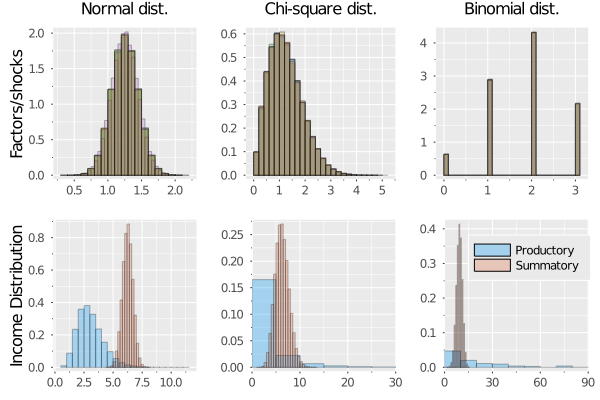

In [263]:
# Random.seed!(123);
theme(:ggplot2)
K    = 5;
S    = 100_000;

function gen_simul(dist; S=100, K=2)
    ϵ    = rand(dist,S,K);
    y    = prod(ϵ,dims=2);  
    x    = sum(ϵ,dims=2);
    return y,x,ϵ
end
leg   = ["Productory" "Summatory"];

dist  = Normal(1.25,0.2); 
y,x,ϵ = gen_simul(dist,S=S,K=K);
p1    = histogram(ϵ , bin=30,ylabel="Factors/shocks",title="Normal dist.",label=false,α=0.3,normalize=true,titlefontsize=11);
p2    = histogram([y x],bin=30,α=0.3,ylabel="Income Distribution",normalize=true,label=false);

dist  = Chi(2); 
y,x,ϵ = gen_simul(dist,S=S,K=K);
p3    = histogram(ϵ , bin=30,label=false,α=0.3,normalize=true,title="Chi-square dist.",titlefontsize=11);
p4    = histogram([y x],bin=30,α=0.3,normalize=true,label=false,xlim=(0,30));

dist  = Binomial(3,0.6); 
y,x,ϵ = gen_simul(dist,S=S,K=K);
p5    = histogram(ϵ , bin=30,label=false,α=0.3,normalize=true,title="Binomial dist.",titlefontsize=11);
p6    = histogram([y x],bin=30,α=0.3,normalize=true,label=false,labels=leg,legend=(0.5,0.8),xlim=(0,90));

plot(p1,p3,p5,p2,p4,p6,layout=(2,3))

> It is evident that the **productory** aggregation function generates swekness and fat tails while, unsurprisingly, the **summatory** aggregator is symmetric and bell-shaped. However, there are two problems with the pure log-normal/Gibrat approach:
> 1. Such process implies ever growing variance in the overall distribution of log-earnings. Therefore, asumming $K\rightarrow \infty$, an stationary distribution of income does not exists.
> 2. Even if we assume a fixed $K$, observed income distributions tend to have tails that are thicker and longer than the log-normal. 

During 1950-1970s, various economists devised different auxiliary stabilizing hypothesis to offset the tendency for increasing variance and solves problem 1. On the other hand, problem 2 immediately discards log-normal distributions as plausible generative mechanism for income distributions. Other theories are needed to fit the upper tail of income distribution. We will return to these different theories below. 

**Correlated factors/increments**. There is an easy way to account for the extra concentration of mass in the tail. Put simply, it just consists in letting the factors that generates income to be positive correlated.

First, the following code performs the previous exercise but with correlated factors.

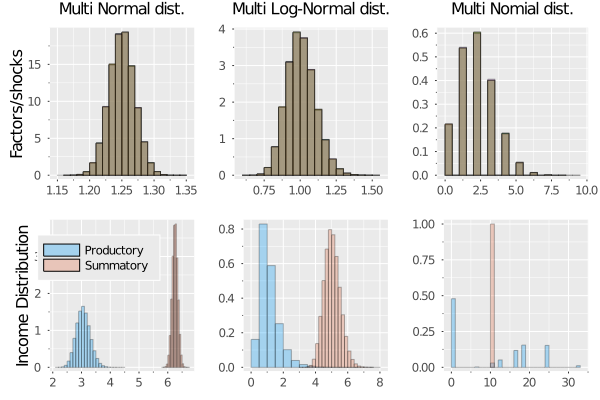

In [266]:
Random.seed!(123)
function gen_simul_corr(dist; S=100)
    ϵ    = rand(dist,S)';
    y    = prod(ϵ,dims=2);  
    x    = sum(ϵ,dims=2);
    return y,x,ϵ
end

# Multinormal
P1  = ones(K,K);  
P1[diagind(P1)] .= 0;
dist = MvNormal(1.25*ones(K), 0.02^2*I + 0.99*0.02^2*P1); 
y, x, ϵ = gen_simul_corr(dist,S=S);
p1   = histogram(ϵ , bin=30,ylabel="Factors/shocks",title="Multi Normal dist.",label=false,α=0.3,normalize=true,titlefontsize=11);
p2   = histogram([y x],bin=30,α=0.3,ylabel="Income Distribution",normalize=true,labels=leg,legend=(0.4,0.8));

# Multilognormal
dist = MvLogNormal(MvNormal(0.001*ones(K), 0.1^2*I + 0.99*0.1^2*P1)); 
y, x, ϵ = gen_simul_corr(dist,S=S);
p3   = histogram(ϵ,bin=30,title="Multi Log-Normal dist.",label=false,α=0.3,normalize=true,titlefontsize=11);
p4   = histogram([y x],bin=30,α=0.3,normalize=true,label=false);

# Multinomial
pv   = ones(K);
dist = Multinomial(10, pv/sum(pv)); 
y, x, ϵ = gen_simul_corr(dist,S=S);
p5   = histogram(ϵ,bin=30,title="Multi Nomial dist.",label=false,α=0.3,normalize=true,titlefontsize=11);
p6   = histogram([y x],bin=30,α=0.3,normalize=true,label=false);

plot(p1,p3,p5,p2,p4,p6,layout=(2,3))

Second, we examine the consequences of negative and positive correlation in income distribution. As expected, a positive correlation help us to account an extra mass in the upper tail of the income distribution.

In [361]:
Random.seed!(123);
leg    = ["Correl<0" "Correl=0" "Correl>0"];

# Multinormal
dist   = MvNormal(1.25*ones(K), 0.2^2*I - 0.24*0.2^2*P1); 
y1,~,~ = gen_simul_corr(dist,S=S);
dist   = MvNormal(1.25*ones(K), 0.2^2*I + 0.0*P1); 
y2,~,~ = gen_simul_corr(dist,S=S);
dist   = MvNormal(1.25*ones(K), 0.2^2*I + 0.99*0.2^2*P1); 
y3,~,~ = gen_simul_corr(dist,S=S);

p1     = histogram([y1 y2 y3],bin=100,α=0.3,label=false,ylabel="Multi Normal dist.",title="Income Distribution",normalize=true,xlim=(0,10),titlefontsize=11);
p2     = boxplot(leg,[y1 y2 y3],legend=false,outliers=false,α=0.4,title="Boxplot (no outliers)",titlefontsize=11);
p3     = boxplot(leg,[y1 y2 y3],legend=false,α=0.4,title="Boxplot",markersize=3,titlefontsize=11);

# Multilognormal
dist   = MvLogNormal(MvNormal(0.001*ones(K), 0.2^2*I - 0.24*0.2^2*P1)); 
y1,~,~ = gen_simul_corr(dist,S=S);
dist   = MvLogNormal(MvNormal(0.001*ones(K), 0.2^2*I + 0.0*P1)); 
y2,~,~ = gen_simul_corr(dist,S=S);
dist   = MvLogNormal(MvNormal(0.001*ones(K), 0.2^2*I + 0.99*0.2^2*P1)); 
y3,~,~ = gen_simul_corr(dist,S=S);

p4     = histogram([y1 y2 y3],labels=leg,legend=(0.5,0.8),bin=100,α=0.3,normalize=true,label=false,ylabel="Multi Log-Normal dist.",xlim=(0,10));
p5     = boxplot(leg,[y1 y2 y3],legend=false,outliers=false,α=0.4);
p6     = boxplot(leg,[y1 y2 y3],legend=false,markersize=3,α=0.4);

plot(p1,p2,p3,p4,p5,p6,layout=(2,3))

Third, we illustrate the example of correlated increments given in Neal and Rosen (2000) in section 1.2. Consider a statistical factor-analytic structure with a single factor $1+\lambda$ (e.g. IQ) and suppose that personal endowments of the specific $\epsilon$-inputs follow $\epsilon_i=u_i(1+\lambda)$, where $u_i$ is independently distributed. Then, the productory aggregator implies that the personal income is $y= (1+\lambda)^K\prod_{i=1}^Ku_i$.

The exercise below shows that even if $1+\lambda$ is symmetric and normally distributed, together with $u_i$ being uniformly distributed, the distribution of $y$ has a long right tail. Moreover, it shows that the single factor is necessary in order to generate that extra concentration in the upper tail.   

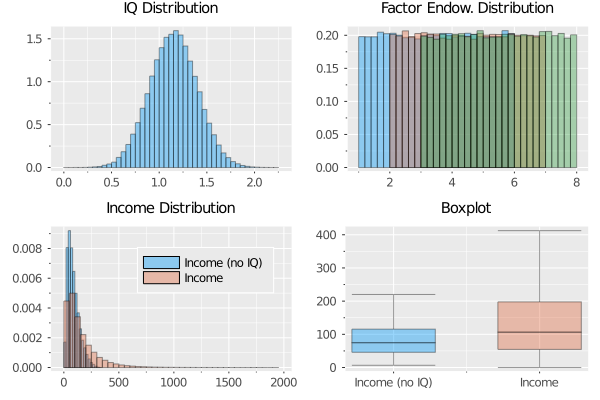

In [445]:
K      = 3;
lambda = 0.15 .+ 0.25*randn(S);
leg    = ["Income (no IQ)" "Income"];
u      = zeros(S,K);

for i in 1:K
    dist   = Uniform(0+i,5+i);
#    dist   = Poisson(i);
    u[:,i] = rand(dist,S);
end

x      = prod(u,dims=2);
y      = x.*(1 .+ lambda).^K;

p1     = histogram(1 .+ lambda,α=0.4,bins=40,title="IQ Distribution",label=false,normalize=true,titlefontsize=10);
p2     = histogram(u, α=0.4, bins=40, title="Factor Endow. Distribution",label=false,normalize=true,titlefontsize=10);
p3     = histogram([x y], α=0.4, bins=[20 50], title="Income Distribution",label=leg,normalize=true,titlefontsize=10);
p4     = boxplot(leg,[x y], α=0.4, title="Boxplot",label=false,titlefontsize=10,outliers=false);

plot(p1,p2,p3,p4,layout=(2,2))